# PROYECTO DESPLIEGUE DE ALGORITMOS

## Instalación de librerias.

In [4]:
!pip install mlflow
!pip install nltk
!pip install -U spacy download en_core_web_sm
!pip install pyngrok
!pip install fastapi

## Conectar con el almacenamiento de GoogleDrive.

In [6]:
# Conectar con el almacenamiento de GoogleDrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Función para guardar datos con formato pkl.

In [7]:
import pickle
def save_pkl(df,file_name, path='/content/drive/MyDrive/despliegueAlgortimos/'):
  rute = path + file_name
  with open(rute, 'wb') as f:
    pickle.dump(df, f)

 ## Función para imprimir metricas.

In [8]:
def print_metricas(pred, y):
  print('Matriz de confusion en Train:')
  cm = confusion_matrix(y, pred)
  print(cm)
  target_names = ['0', '1']
  # Graficar la matriz de confusión
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

  print('---------------------------------------------')
  print('Metricas:')
  print(classification_report(y, pred))

# 1. CLASIFICACION DE DOCUMENTOS CON SCIKIT LEARN Y MLFLOW

  He elegido para este proyecto descargar un dataset de reviews de amazon de productos relacionados con el deporte y las actividades al aire libre. Como el dicho dataset es excesivamente grande para tratar en un entorno de Google Colab gratuito, por la limitación de recursos he descargado un subset balanceado para este proyecto.

  Sobre dicho dataset se va a realizar un análisis de sentimientos que clasifique las reviews en positivas y negativas.

  He aprovechado el proyecto previo de NLP para ello, que pueden encontrar en:

  https://github.com/elsdragon/NLPproyect

  ## 1.1 Exploración de los datos:
  
  Analisis previo del conjunto de datos proporcionado para comprender su estructura y contenido.

  Carga del dataset y comprobación.





In [9]:
import pandas as pd
data_sports = pd.read_csv('/content/drive/MyDrive/despliegueAlgortimos/df_sports_subset2.csv')

In [10]:
data_sports.head()

,sentimiento,review
0,4.0,Perfect size to fit in an emergency preparedne...
1,4.0,Great but wears out pretty quick if used a lot...
2,5.0,Great item that is superbly inexpensive for it...
3,5.0,This is a sturdily built portable practice net...
4,4.0,works good


In [11]:
data_sports.shape

(30000, 2)

In [12]:
data_sports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sentimiento  30000 non-null  float64
 1   review       30000 non-null  object 
dtypes: float64(1), object(1)
memory usage: 468.9+ KB


In [ ]:
data_sports.describe()

,sentimiento
count,30000.000000
mean,3.520667
std,1.431936
min,1.000000
25%,3.000000
50%,3.500000
75%,5.000000
max,5.000000


In [ ]:
data_sports.columns

Index(['sentimiento', 'review'], dtype='object')

El dataset tiene 30000 resgistros con 2 columnas una con las reviews y otra con la valoración entre 1 y 5 estrellas.

Se ha elegido un dataset balanceado en cuanto a estas valoraciones.

Funciones para hacer un análisis del tipo de tokens que tiene nuestro corpus.

In [ ]:
import spacy

# Cargar modelo en ingles pequeño
nlp = spacy.load('en_core_web_sm')

# Función para visulizar en una tabla información de los token
def token_information(doc):
    # Cabecera
    header = '{:<10}{:<10}{:<10}{:<10}{:<20}'.format('Token', 'POS', 'Tag', 'Dep', 'Meaning')
    print(header)
    print('-' * len(header))

    for token in doc:
        meaning = spacy.explain(token.dep_) or 'N/A'
        print('{:<10}{:<10}{:<10}{:<10}{:<20}'.format(token.text, token.pos_, token.tag_, token.dep_, meaning))

# Función para procesar el texto e imprimir lo anterior
def process_and_display_token_info(text):
    doc = nlp(text)
    token_information(doc)

In [ ]:
data_sports['review'].head(5).apply(process_and_display_token_info)

Token     POS       Tag       Dep       Meaning             
------------------------------------------------------------
Perfect   ADJ       JJ        amod      adjectival modifier 
size      NOUN      NN        ROOT      root                
to        PART      TO        aux       auxiliary           
fit       VERB      VB        relcl     relative clause modifier
in        ADP       IN        prep      prepositional modifier
an        DET       DT        det       determiner          
emergency NOUN      NN        compound  compound            
preparednessNOUN      NN        compound  compound            
backpack  NOUN      NN        pobj      object of preposition
that      PRON      WDT       dobj      direct object       
we        PRON      PRP       nsubj     nominal subject     
started   VERB      VBD       relcl     relative clause modifier
.         PUNCT     .         punct     punctuation         
          SPACE     _SP       dep       unclassified dependent
Should   

0    None
1    None
2    None
3    None
4    None
Name: review, dtype: object

Análisis de frecuencias de palabras.

In [ ]:
def most_common(review, number):
  words_nltk = review.lower().split()
  wf = Counter(words_nltk)
  return wf.most_common(number), words_nltk

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
corpus = data_sports['review'].str.cat(sep=' ')
print('Nº token del corpus: ',len(corpus))

Nº token del corpus:  8282782


In [ ]:
most_common_words, words_nltk = most_common(corpus, 10)
most_common_words

[('the', 79221),
 ('i', 44925),
 ('a', 41554),
 ('and', 41036),
 ('to', 39738),
 ('it', 33970),
 ('is', 24074),
 ('for', 21879),
 ('of', 21020),
 ('this', 19418)]

Análisis de N-GRAMAS (Bigramas y trigramas)

In [ ]:
from nltk import ngrams
from nltk.probability import FreqDist

In [ ]:
bigrams_ = list(ngrams(words_nltk, 2))
trigrams_ = list(ngrams(words_nltk, 3))
bigrams_[:10]

[('perfect', 'size'),
 ('size', 'to'),
 ('to', 'fit'),
 ('fit', 'in'),
 ('in', 'an'),
 ('an', 'emergency'),
 ('emergency', 'preparedness'),
 ('preparedness', 'backpack'),
 ('backpack', 'that'),
 ('that', 'we')]

In [ ]:
trigrams_[:10]

[('perfect', 'size', 'to'),
 ('size', 'to', 'fit'),
 ('to', 'fit', 'in'),
 ('fit', 'in', 'an'),
 ('in', 'an', 'emergency'),
 ('an', 'emergency', 'preparedness'),
 ('emergency', 'preparedness', 'backpack'),
 ('preparedness', 'backpack', 'that'),
 ('backpack', 'that', 'we'),
 ('that', 'we', 'started.')]

In [ ]:
bg_freq = FreqDist(bigrams_)
tg_freq = FreqDist(trigrams_)
bg_freq.most_common(10)

[(('of', 'the'), 5745),
 (('in', 'the'), 4805),
 (('on', 'the'), 4296),
 (('it', 'is'), 3942),
 (('i', 'have'), 3536),
 (('for', 'the'), 3134),
 (('is', 'a'), 3081),
 (('and', 'the'), 2905),
 (('this', 'is'), 2749),
 (('for', 'a'), 2722)]

In [ ]:
tg_freq.most_common(10)

[(('this', 'is', 'a'), 909),
 (('a', 'lot', 'of'), 625),
 (('out', 'of', 'the'), 585),
 (('i', 'had', 'to'), 552),
 (('it', 'is', 'a'), 522),
 (('i', 'bought', 'this'), 518),
 (('if', 'you', 'are'), 472),
 (('one', 'of', 'the'), 462),
 (('i', 'have', 'a'), 394),
 (('i', 'like', 'the'), 378)]

Hay muchas palabras que no aportan nada y que tenemos que eliminar.

Visualización de palabras con WORDCLOUD.

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

Función que pinta la visualización.

In [ ]:
# Función para pintar gráfico wordcloud.
def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(text))
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

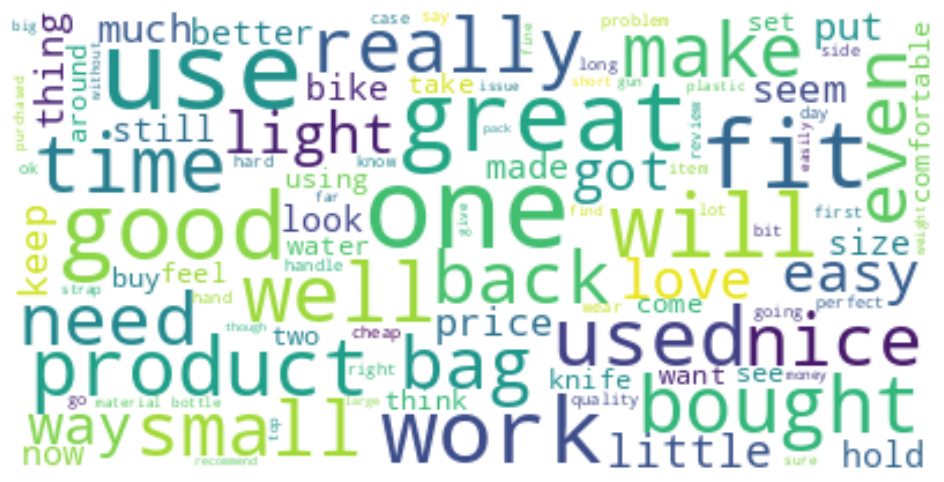

In [ ]:
words_list = corpus.lower().strip().split()
plot_word_cloud(words_list)

  ## 1.2. Preprocesamiento del texto.

  Tareas de preprocesamiento de texto, como tokenización y vectorización, para preparar los datos para el modelado.


Con el estudio previo vamos a normalizar con los siguientes pasos:

a) Quitar signos extraños y signos de puntuación.

b) Eliminar stop words

c) Lematizar los tokens.

d) Pasar a minúsculas.

e) Eliminar links a paginas web.

f) Eliminar tokens menores de 3 caracteres.

Cargar librerias.

In [13]:
import pandas as pd
import numpy as np
import spacy
import unicodedata
from bs4 import BeautifulSoup
import re
from sklearn.model_selection import train_test_split
import pickle
import warnings
warnings.filterwarnings('ignore')

Funciones para la normalización.

In [14]:
# Cargar modelo en ingles pequeño
nlp = spacy.load('en_core_web_sm')

# Normalización Unicode para eliminar caracteres extraños
def unicode_normalize(text):
  return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

# Quitar puntuaciones, digitos stopwords, longitud menor a 3 etc....
def token_out(token):
  return token.is_punct or token.is_digit or token.is_stop or re.match(r"[^a-zA-Z0-9]", token.text) or len(token)<3

# Función de normalización
def normalize_text(text):
    text = unicode_normalize(text)
    text = BeautifulSoup(text, "html5lib").get_text()
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    # Procesar el texto con Spacy
    doc = nlp(text)
    # Normalización de tokens
    normalized_tokens = []
    for token in doc:
        # Comprobar si es un signo de puntuación o digito o stop word
        if token_out(token):
            # Continuar
            continue

        # Tratar el resto de casos
        else:
            # lametizamos y convertir en minusculas
            normalized_tokens.append(token.lemma_.lower())


    # Unir tokens normalizados
    normalized_text = " ".join(normalized_tokens)
    return normalized_text

Aplicamos la función de normalización a la columna review.

In [15]:
data_sports['review'] = data_sports['review'].apply(normalize_text)
data_sports.head()

,sentimiento,review
0,4.0,perfect size fit emergency preparedness backpa...
1,4.0,great wear pretty quick lot rinse son swim day...
2,5.0,great item superbly inexpensive performance
3,5.0,sturdily build portable practice net change re...
4,4.0,work good


Codificar las estrellas de las reviews con un 1 si son mayores o iguales a 4 y con 0 el resto.
1 Será un sentimiento positivo y 0 negativo.

In [16]:
data_sports['sentimiento'] = data_sports['sentimiento'].apply(lambda x: 1 if x >= 4 else 0)
data_sports.head()

,sentimiento,review
0,1,perfect size fit emergency preparedness backpa...
1,1,great wear pretty quick lot rinse son swim day...
2,1,great item superbly inexpensive performance
3,1,sturdily build portable practice net change re...
4,1,work good


Guardar csv con el dataset normalizado

In [17]:
data_sports.to_csv('/content/drive/MyDrive/despliegueAlgortimos/sports_clean.csv', index=False)

Carga del archivo ya normalizado.

In [18]:
data_sports = pd.read_csv('/content/drive/MyDrive/despliegueAlgortimos/sports_clean.csv')
data_sports.head()

,sentimiento,review
0,1,perfect size fit emergency preparedness backpa...
1,1,great wear pretty quick lot rinse son swim day...
2,1,great item superbly inexpensive performance
3,1,sturdily build portable practice net change re...
4,1,work good


Eliminación de nulos y duplicados.

In [19]:
data_sports = data_sports.dropna().drop_duplicates()
data_sports.isna().any()

sentimiento    False
review         False
dtype: bool

División entre Train y Test.

In [20]:
# Dividir train test
train, test = train_test_split(data_sports, test_size=0.2, stratify=data_sports['sentimiento'], random_state=42)

train.to_csv('/content/drive/MyDrive/despliegueAlgortimos/sports_train.csv', index=False)
test.to_csv('/content/drive/MyDrive/despliegueAlgortimos/sports_test.csv', index = False)

Comprobación de los shape de cada dataset y de la distribución de la variable objetivo.

Con la eliminación de duplicados y nulos ha variado la distribución.

In [21]:
print(train.shape)
train['sentimiento'].value_counts()

(22345, 2)


sentimiento
0    11551
1    10794
Name: count, dtype: int64

In [22]:
print(test.shape)
test['sentimiento'].value_counts()

(5587, 2)


sentimiento
0    2888
1    2699
Name: count, dtype: int64

Guardar Train y Test como csv.

In [23]:
train = pd.read_csv('/content/drive/MyDrive/despliegueAlgortimos/sports_train.csv')
test = pd.read_csv('/content/drive/MyDrive/despliegueAlgortimos/sports_test.csv')

Separar la variable objetivo sentimiento de la variable review. Guardar los nuevos datos con formato pkl.

In [24]:
X_train = train['review']
y_train = train['sentimiento']

X_test = test['review']
y_test = test['sentimiento']


# Guardar los conjuntos de datos
save_pkl(y_train, 'y_train.pkl')
save_pkl(X_train, 'X_train.pkl')
save_pkl(y_test, 'y_test.pkl')
save_pkl(X_test, 'X_test.pkl')

Vectorizar la variable review con CountVectorizer y guardar los datos.

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
# CountVectorizer simple
count_simple = CountVectorizer()
X_train_cv_simple = count_simple.fit_transform(X_train)
X_test_cv_simple = count_simple.transform(X_test)

# Guardar las matrices transformadas
save_pkl(X_train_cv_simple, 'X_train_cv.pkl')
save_pkl(X_test_cv_simple, 'X_test_cv.pkl')


  ## 1.3. Entrenamiento del modelo:
  
  Carga de librerias.


In [26]:

from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


import warnings
warnings.filterwarnings('ignore')

Función para el entranamiento de un modelo de regresión logística.

In [27]:
def model_lr(X_train, y_train, C, f):
  param_grid = {'C': C}
  model = LogisticRegression()
  # Crear el objeto GridSearchCV con LogisticRegression
  grid = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='accuracy')

  # Realizar el ajuste
  grid.fit(X_train, y_train)

  save_pkl(grid, f)

  pred = grid.predict(X_train)

  # Imprimir los mejores parámetros encontrados
  print("Best parameters: {}".format(grid.best_params_))

  return grid, pred




Entrenamiento del modelo.

In [28]:
C_vector = np.logspace(-4, 4, 20)
file_model = 'lr_model.pkl'
model, pred = model_lr(X_train_cv_simple,
         y_train,
         C_vector,
         file_model)

Best parameters: {'C': 0.08858667904100823}


Cargar el modelo guardado.

In [29]:
import pickle

with open("logistic_regression_model.pkl", "wb") as f:
    pickle.dump(model, f)


## 1.4.  Evaluación del Modelo:
Evalúa el rendimiento del modelo utilizando métricas de evaluación estándar como precisión y recall.


Visualización métricas en train.

Metricas en train:
Matriz de confusion en Train:
[[9869 1682]
 [1872 8922]]


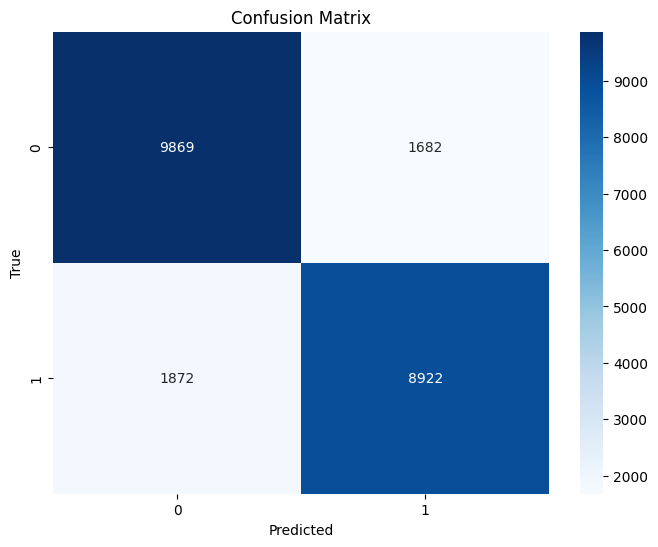

---------------------------------------------
Metricas:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85     11551
           1       0.84      0.83      0.83     10794

    accuracy                           0.84     22345
   macro avg       0.84      0.84      0.84     22345
weighted avg       0.84      0.84      0.84     22345



In [30]:
print('Metricas en train:')
print_metricas(pred, y_train)

Metricas en test.

Metricas en Test:
Matriz de confusion en Train:
[[2397  491]
 [ 598 2101]]


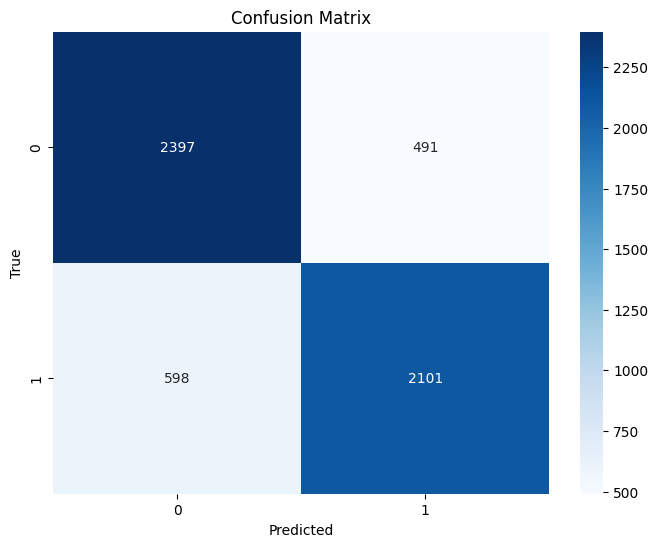

---------------------------------------------
Metricas:
              precision    recall  f1-score   support

           0       0.80      0.83      0.81      2888
           1       0.81      0.78      0.79      2699

    accuracy                           0.81      5587
   macro avg       0.81      0.80      0.80      5587
weighted avg       0.81      0.81      0.80      5587



In [31]:
  pred_test = model.predict(X_test_cv_simple)
  print('Metricas en Test:')
  print_metricas(pred_test, y_test)


El rendimiento del modelo es bastante equilibrado entre precisión y recall, con una exactitud general del 81%. Los F1-scores (que consideran tanto la precisión como el recall) también están bastante equilibrados para ambas clases


  # 2. REGISTRO DE METRICAS CON MLFLOW:
  
  Utiliza MLflow para registrar métricas y hiperparámetros durante el entrenamiento, facilitando la gestión y comparación de experimentos.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
train_accuracy = accuracy_score(y_train, pred)
train_precision = precision_score(y_train, pred)
train_recall = recall_score(y_train, pred)
train_f1 = f1_score(y_train, pred)

test_accuracy = accuracy_score(y_test, pred_test)
test_precision = precision_score(y_test, pred_test)
test_recall = recall_score(y_test, pred_test)
test_f1 = f1_score(y_test, pred_test)

In [ ]:
best_model = model.best_estimator_

In [ ]:
import mlflow
import mlflow.sklearn
mlflow.set_experiment('Sentiment analysis reviews')
with mlflow.start_run(run_name='Logistic Regression Model Deployment'):

    # Logging metrics
    mlflow.log_metrics({
        "train_accuracy": train_accuracy,
        "train_precision": train_precision,
        "train_recall": train_recall,
        "train_f1": train_f1,
        "Test_accuracy": test_accuracy,
        "Test_precision": test_precision,
        "Test_recall": test_recall,
        "Test_f1": test_f1,
    })

    mlflow.log_params({
        "penalty": best_model.penalty,
        "C": best_model.C,
        "solver": best_model.solver,
        "max_iter": best_model.max_iter,
    })
    # Logging the model itself
    mlflow.sklearn.log_model(model, "logistic_regression_model")

In [ ]:
# Set up ngrok and MLflow UI
get_ipython().system_raw('mlflow ui --port 5000 &')

In [ ]:
from pyngrok import ngrok

ngrok.kill()

NGROK_AUTH_TOKEN = '2ihRYvx42ePAeG47J2sqJUPsxUv_coSXJYsmCy6K7JAeVEWA'
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

ngrok_tunnel = ngrok.connect(addr='5000', proto='http', bind_tls=True)
print('The tracking UI:', ngrok_tunnel.public_url)


The tracking UI: https://d49a-34-74-79-40.ngrok-free.app


Capturas de pantalla.

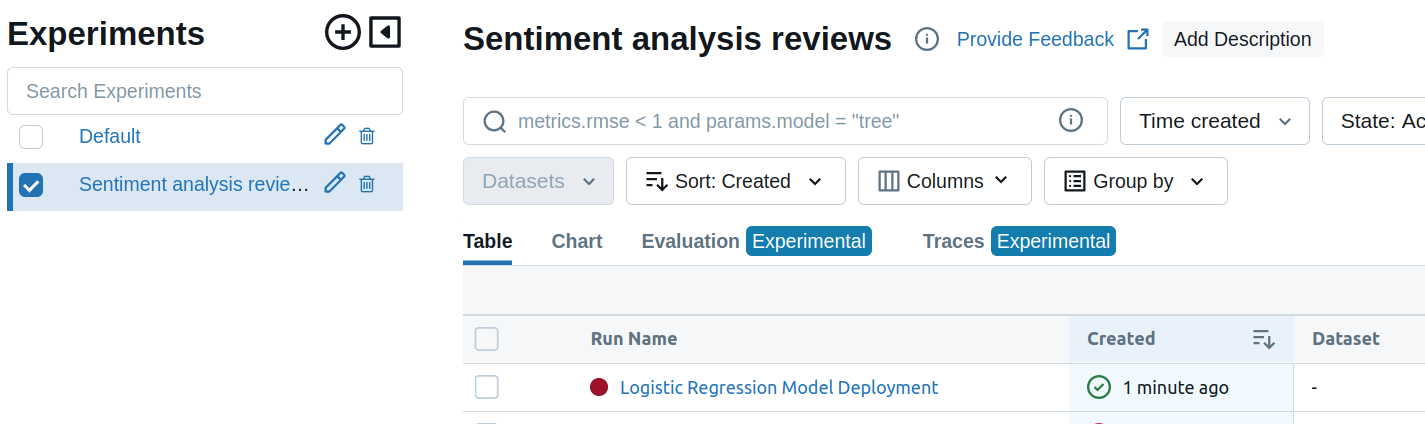

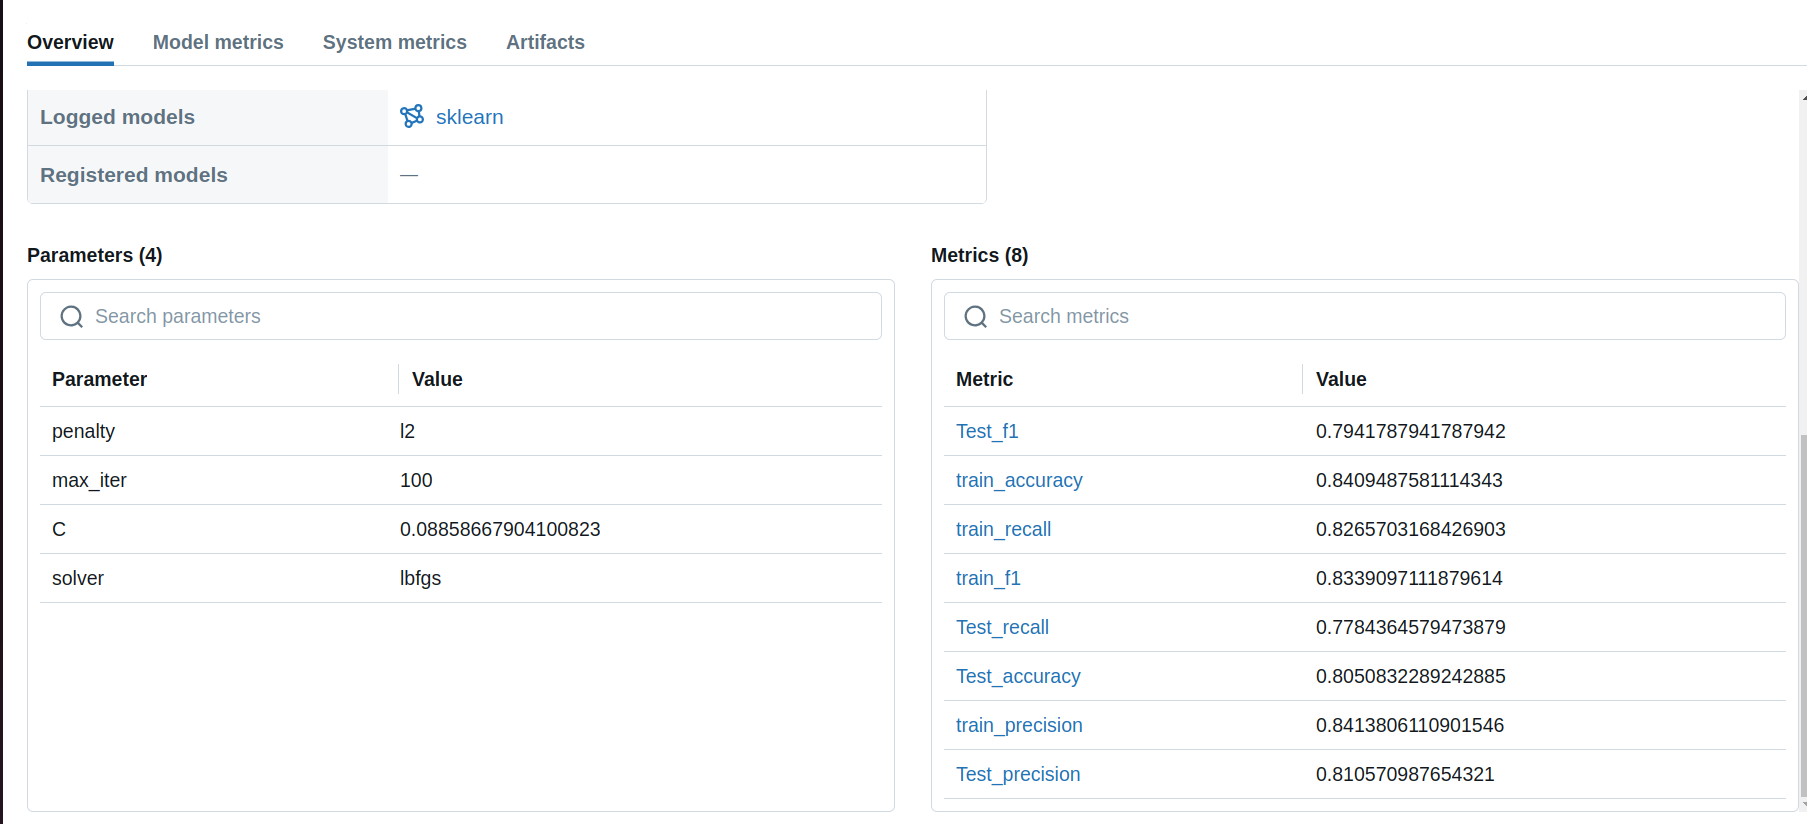

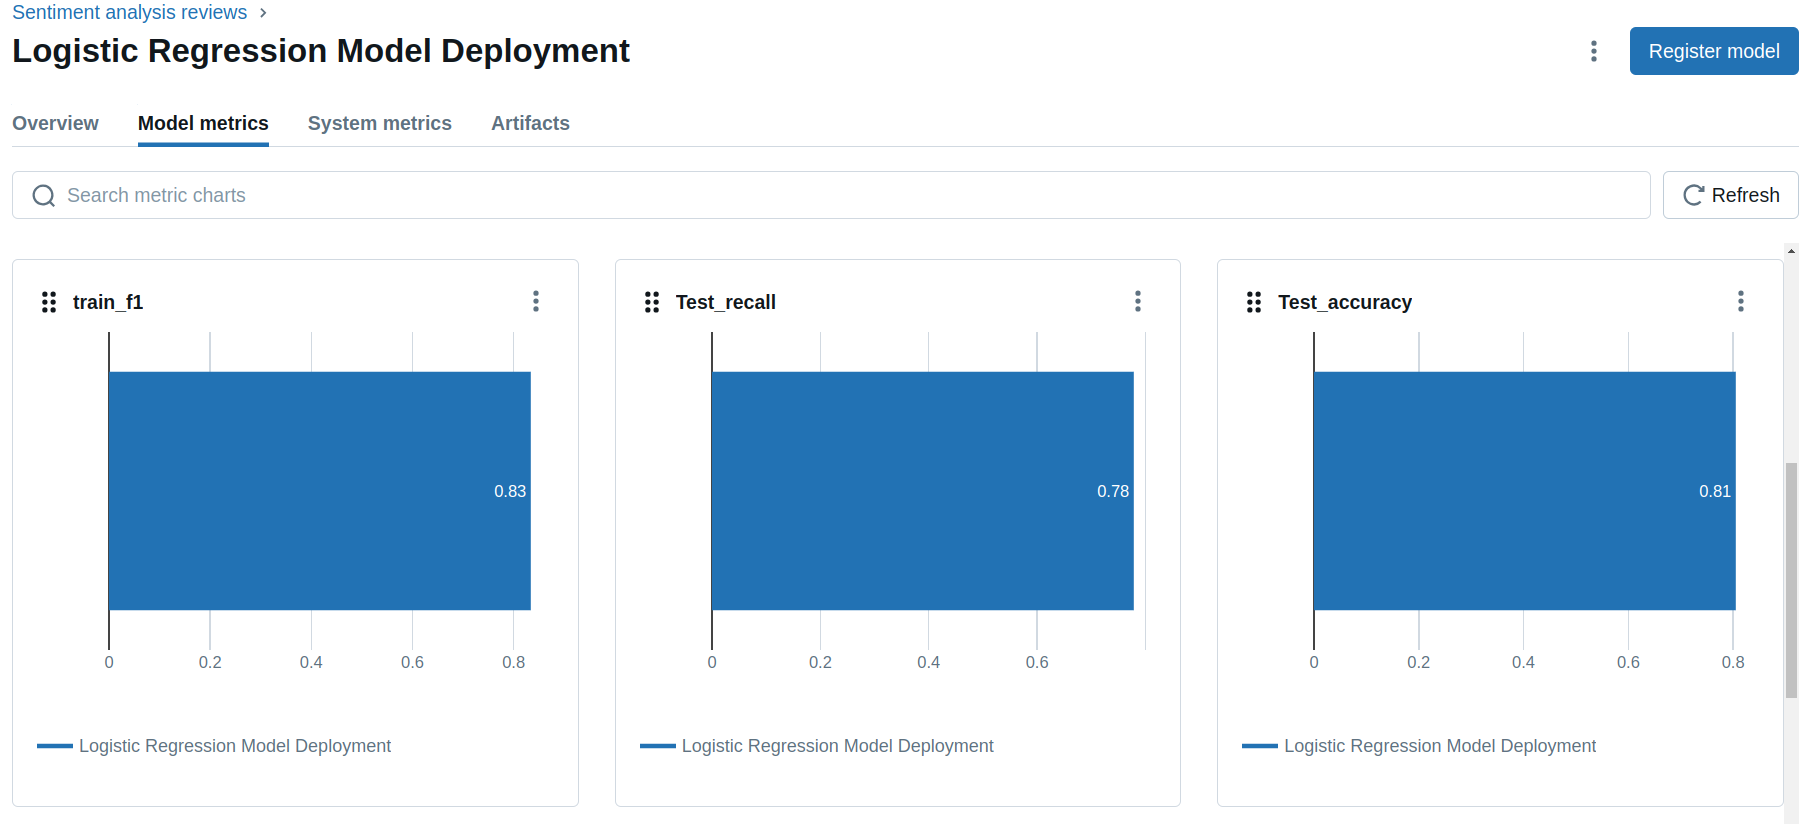

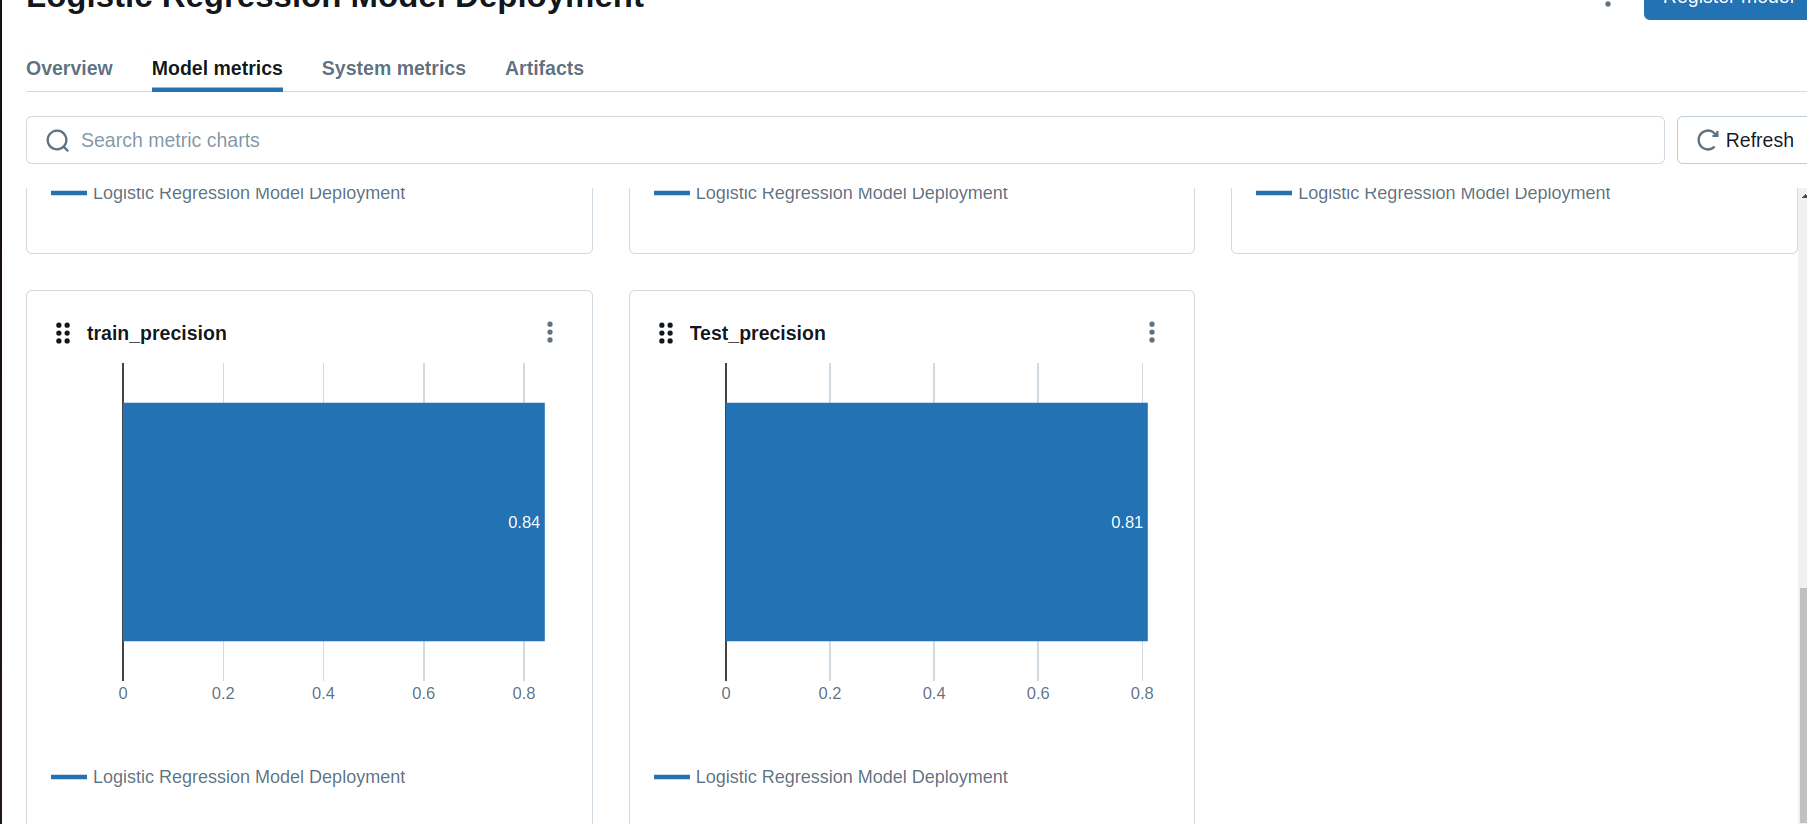

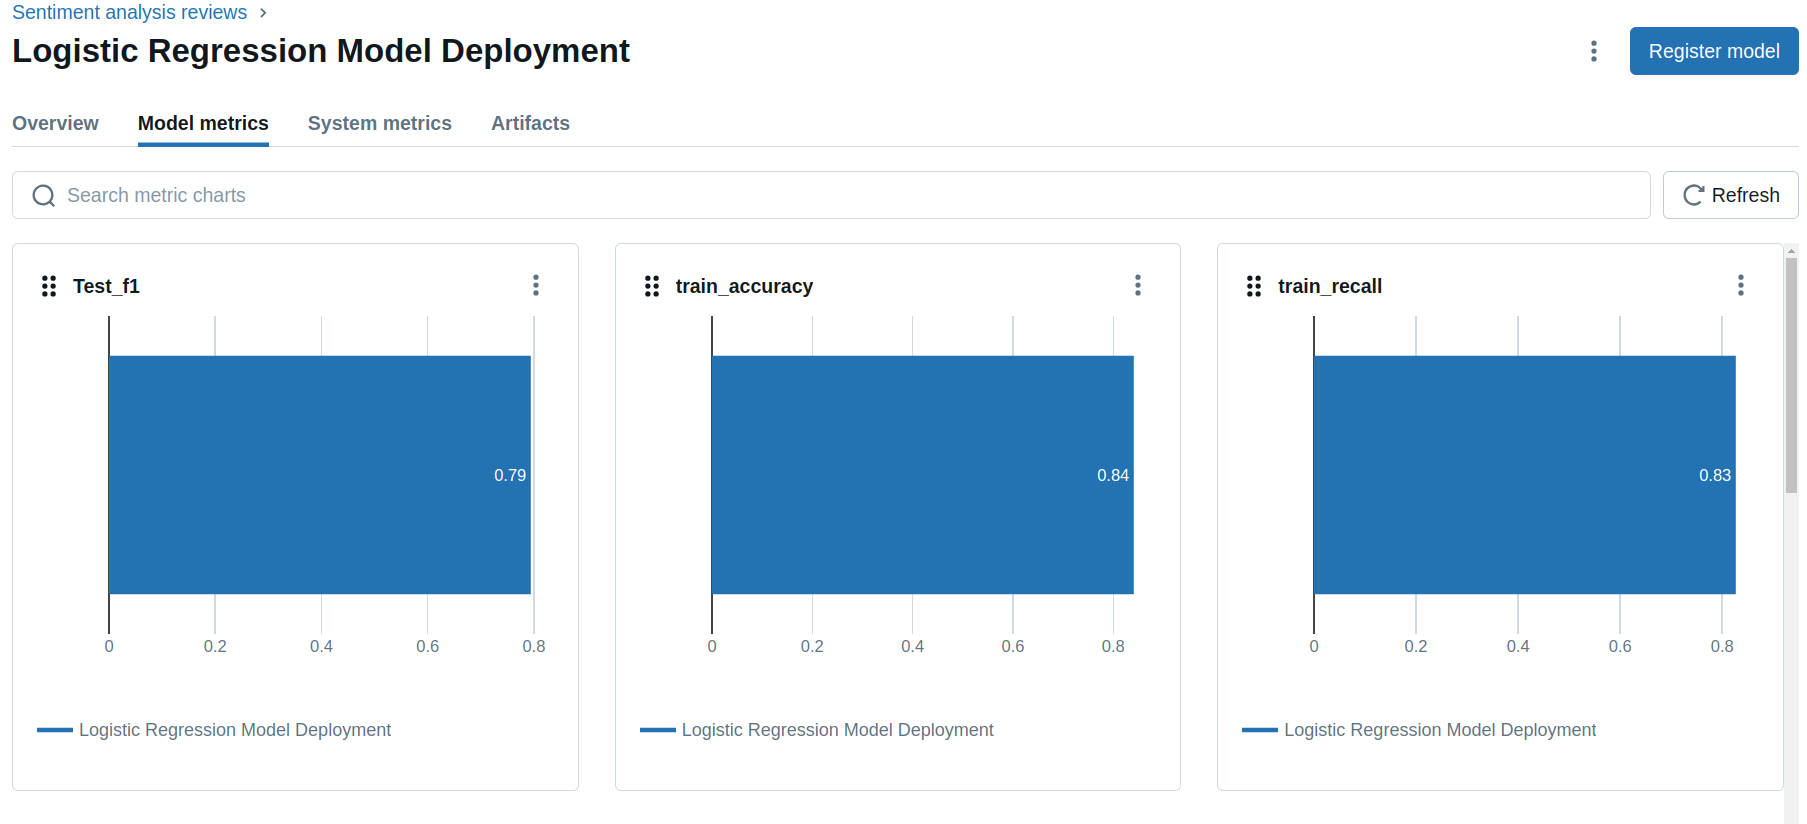

# 3. GENERAR PY DE FUNCIONES:

 Fución main con al menos dos argumentos de entrada.

 Le vamos a pasar como argumento las predicciones y los valores reales para visualizar las métricas y matriz de confusión vistas arriba.

In [ ]:
%%writefile print_metricas.py
import argparse
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def print_metricas(pred, y):
    print('Matriz de confusion en Train:')
    cm = confusion_matrix(y, pred)
    print(cm)
    target_names = ['0', '1']
    # Graficar la matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print('---------------------------------------------')
    print('Metricas:')
    print(classification_report(y, pred))

def main(pred_file, y_file):
    # Load the prediction and true label data from .pkl files
    with open(pred_file, 'rb') as f:
        pred = pickle.load(f)

    with open(y_file, 'rb') as f:
        y = pickle.load(f)

    print_metricas(pred, y)

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Print metrics.')
    parser.add_argument('--pred_file', type=str, required=True, help='Path to the predictions .pkl file')
    parser.add_argument('--y_file', type=str, required=True, help='Path to the true labels .pkl file')

    args = parser.parse_args()
    main(args.pred_file, args.y_file)


Overwriting print_metricas.py


# 4. FastAPI

Generar un script con al menos 5 modulos app.get y dos de ellos tienen que ser pipelines de HF.



Carga de librerias.

In [ ]:
import nest_asyncio
from pyngrok import ngrok, conf
from fastapi import FastAPI
import uvicorn

Script de python.

He diseñado 3 get con un saludo, despedida e información de lo que se puede hacer en la Api.

Luego un get donde pasando una review te dice si es positiva o negativa.

El último pasando una review te dice que productos que salen en la review.

In [ ]:
%%writefile main.py
from fastapi import FastAPI, HTTPException, Query
from pydantic import BaseModel
import numpy as np
from transformers import pipeline
from typing import List, Optional

app = FastAPI()

class Review(BaseModel):
    review_text: str
    features: Optional[List[str]] = None

@app.get('/saludo')
def saluda():
    return {'Message': 'Bienvenidos a mi API.'}

@app.get('/información_api')
def informacion():
  return {'Message': 'Aqui podrás saber el sentimiento de una review y los productos nombrados.'}


@app.get('/generate_sentiment')
def sentiment_classification(review):
    sentiment_pipeline = pipeline('sentiment-analysis')
    sentiment = sentiment_pipeline(review)[0]['label']
    return {'Sentiment': sentiment}


@app.get('/answer_products')
def answer_products_in_review(review):
    qa_model = pipeline('question-answering', model='BSC-LT/roberta-base-bne-sqac')
    answer = qa_model(question="¿Qué productos se mencionan en la review?", context=review)
    return {'Answer': answer['answer']}


@app.get('/despedida')
def saluda():
    return {'Message': 'Gracias por usar mi API.'}


Overwriting main.py


Tunel de ngrok.

In [ ]:
ngrok.kill()

NGROK_TOKEN = '2iuVikuGHXxEebbKr7rkdXrwzDt_2RLvvfEgPj3vcsSGtqQW5'
conf.get_default().auth_token = NGROK_TOKEN

ngrok_tunell = ngrok.connect(8000)
print('Este es el URL,',ngrok_tunell.public_url)
nest_asyncio.apply()

Este es el URL, https://30bf-34-23-96-252.ngrok-free.app


Conectar con FastApi.

In [ ]:
! uvicorn main:app --port 8000

2024-07-07 20:24:06.438797: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 20:24:06.438866: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 20:24:06.440458: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-07 20:24:06.449060: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-07 20:24:08.417043: W tensorflow/compiler/tf2

Ejemplo de request para el get de generate_sentiment.

In [ ]:
import requests

url = 'https://a878-34-74-79-40.ngrok-free.app/generate_sentiment'
text = "Lo bueno es que en cuanto a cantidad y calidad en atracciones de alta intensidad es muy superior a Eurodisney"

json = {'review_text': text}

response = requests.get(url, json=json)

# Manejo de la respuesta
if response.status_code == 200:
    data = response.json()
    print('Respuesta:', data)
else:
    print('Error en la solicitud:', response.status_code)



Error en la solicitud: 404


Capturas de pantalla.

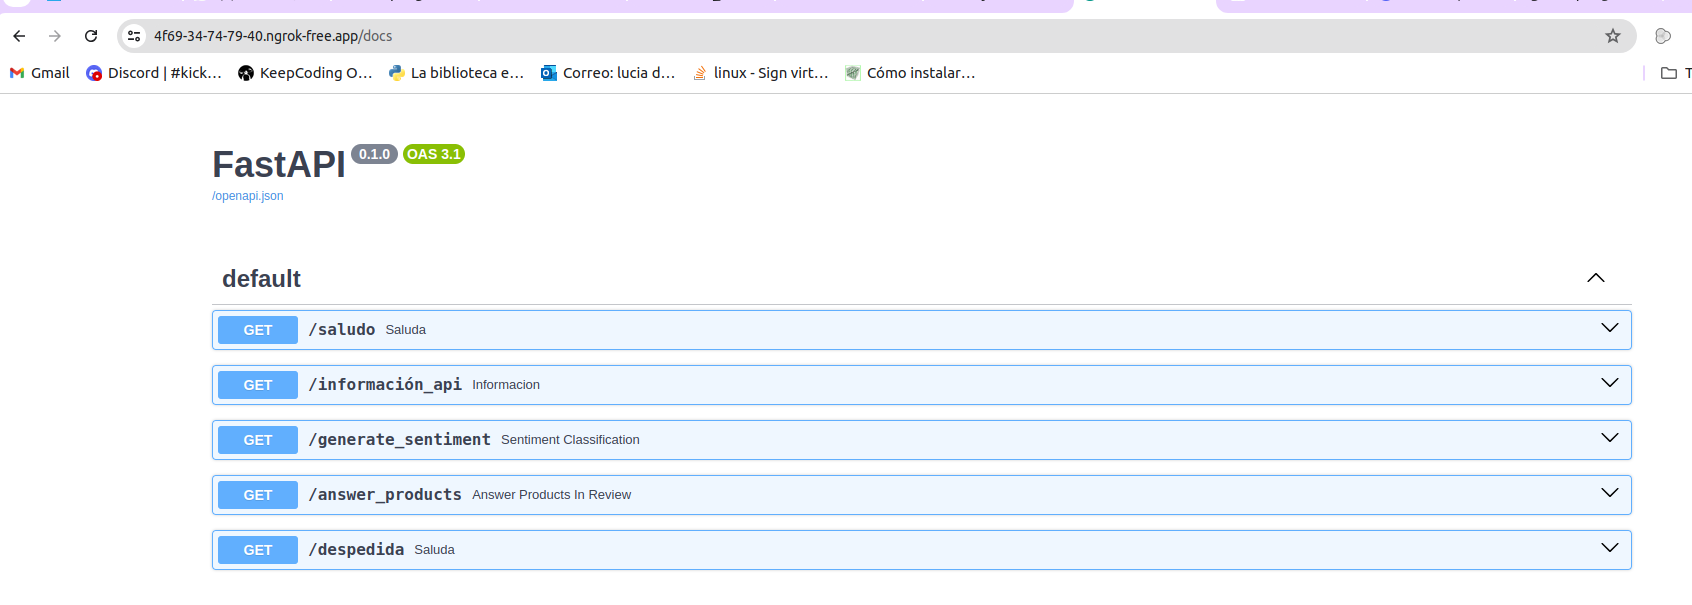

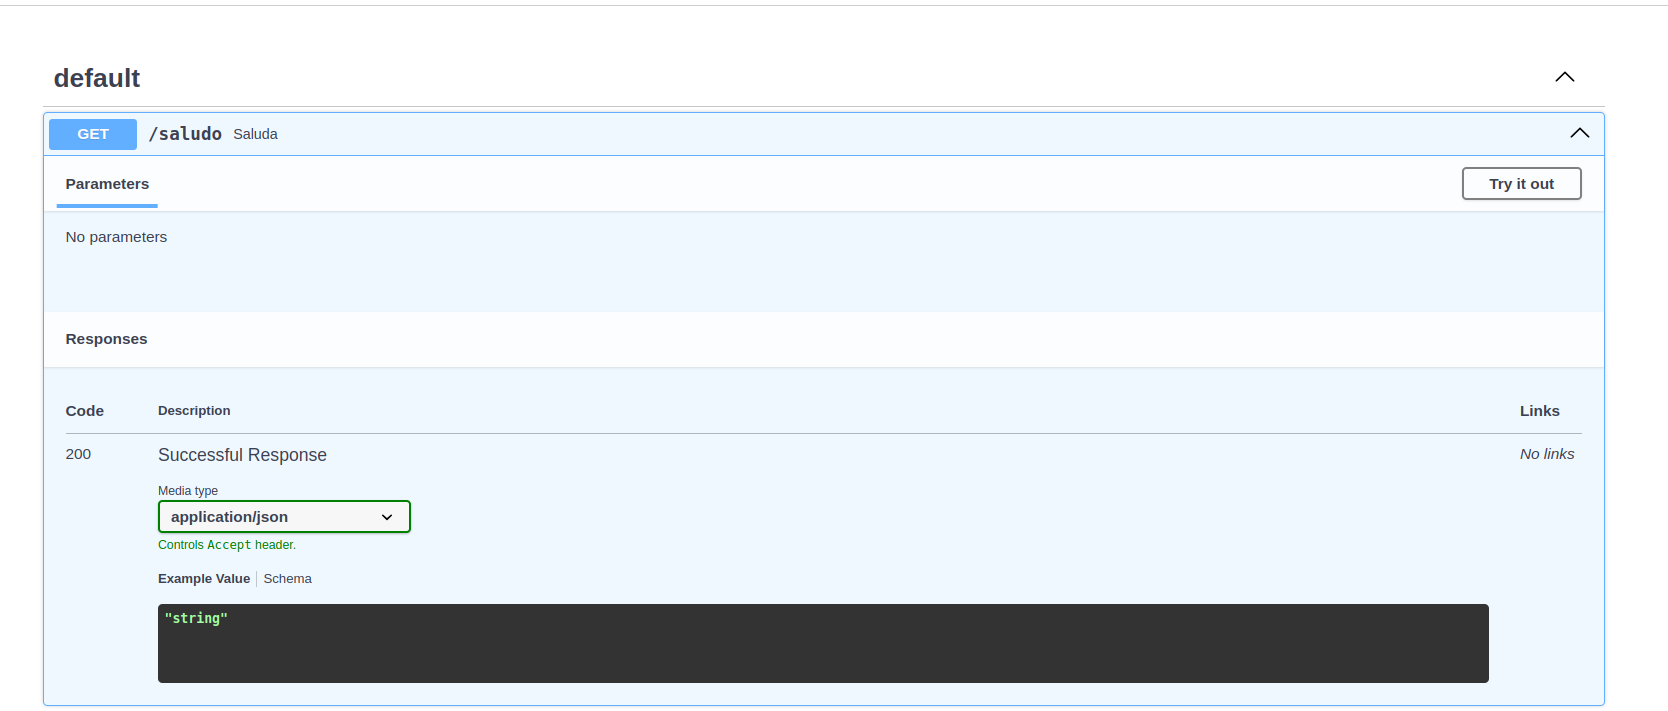

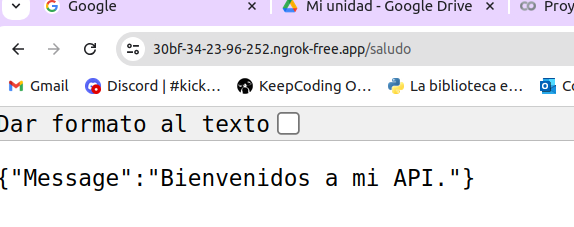

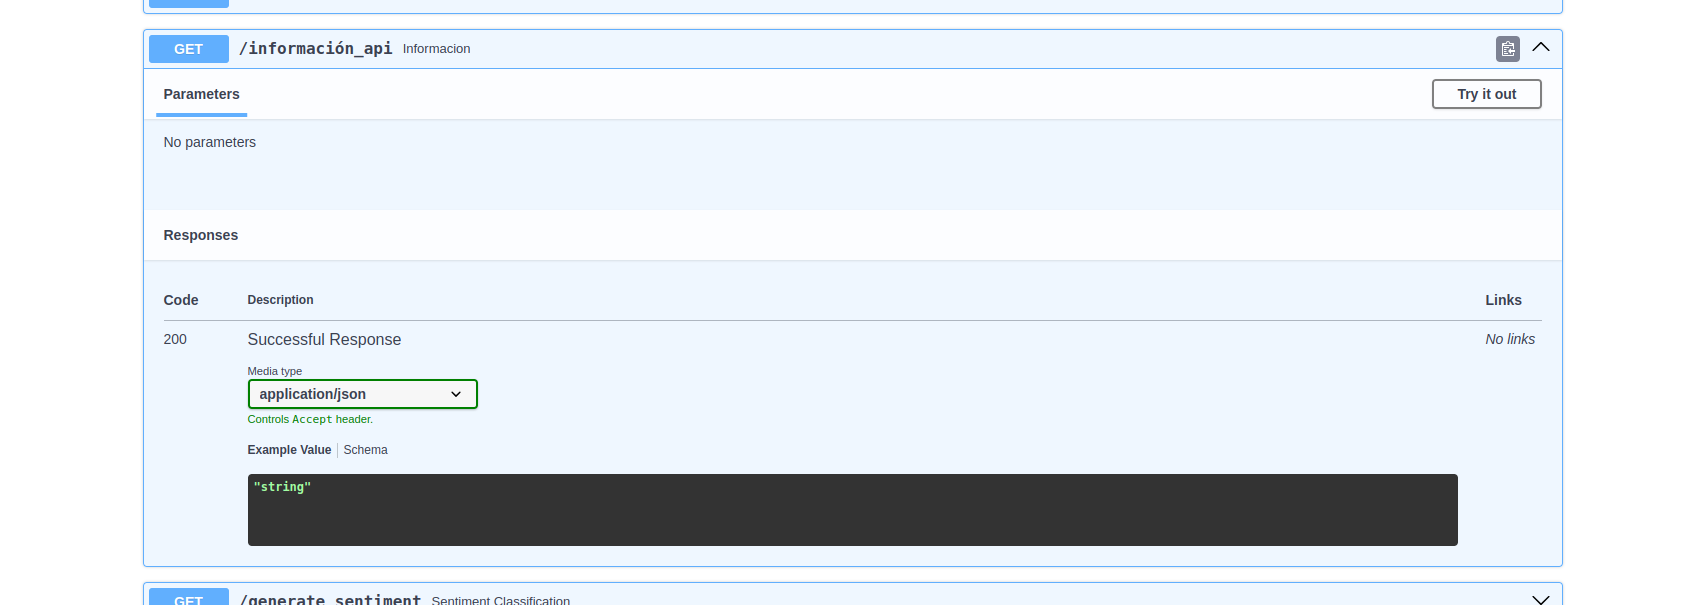

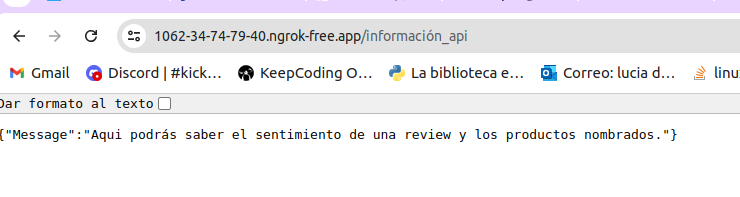

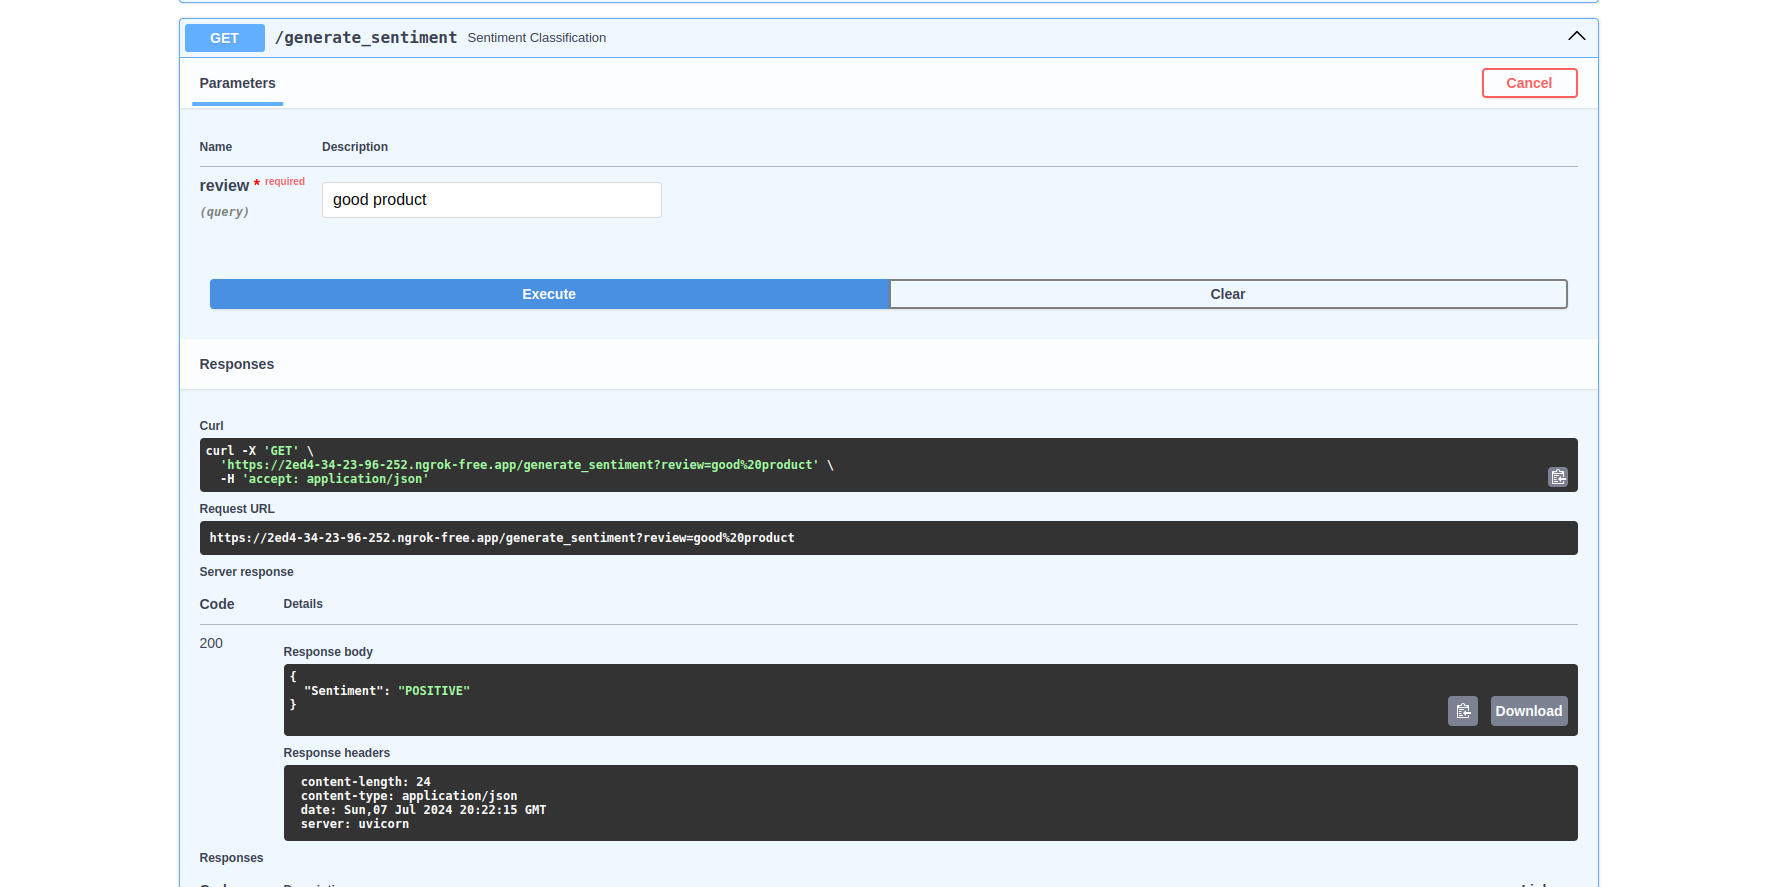

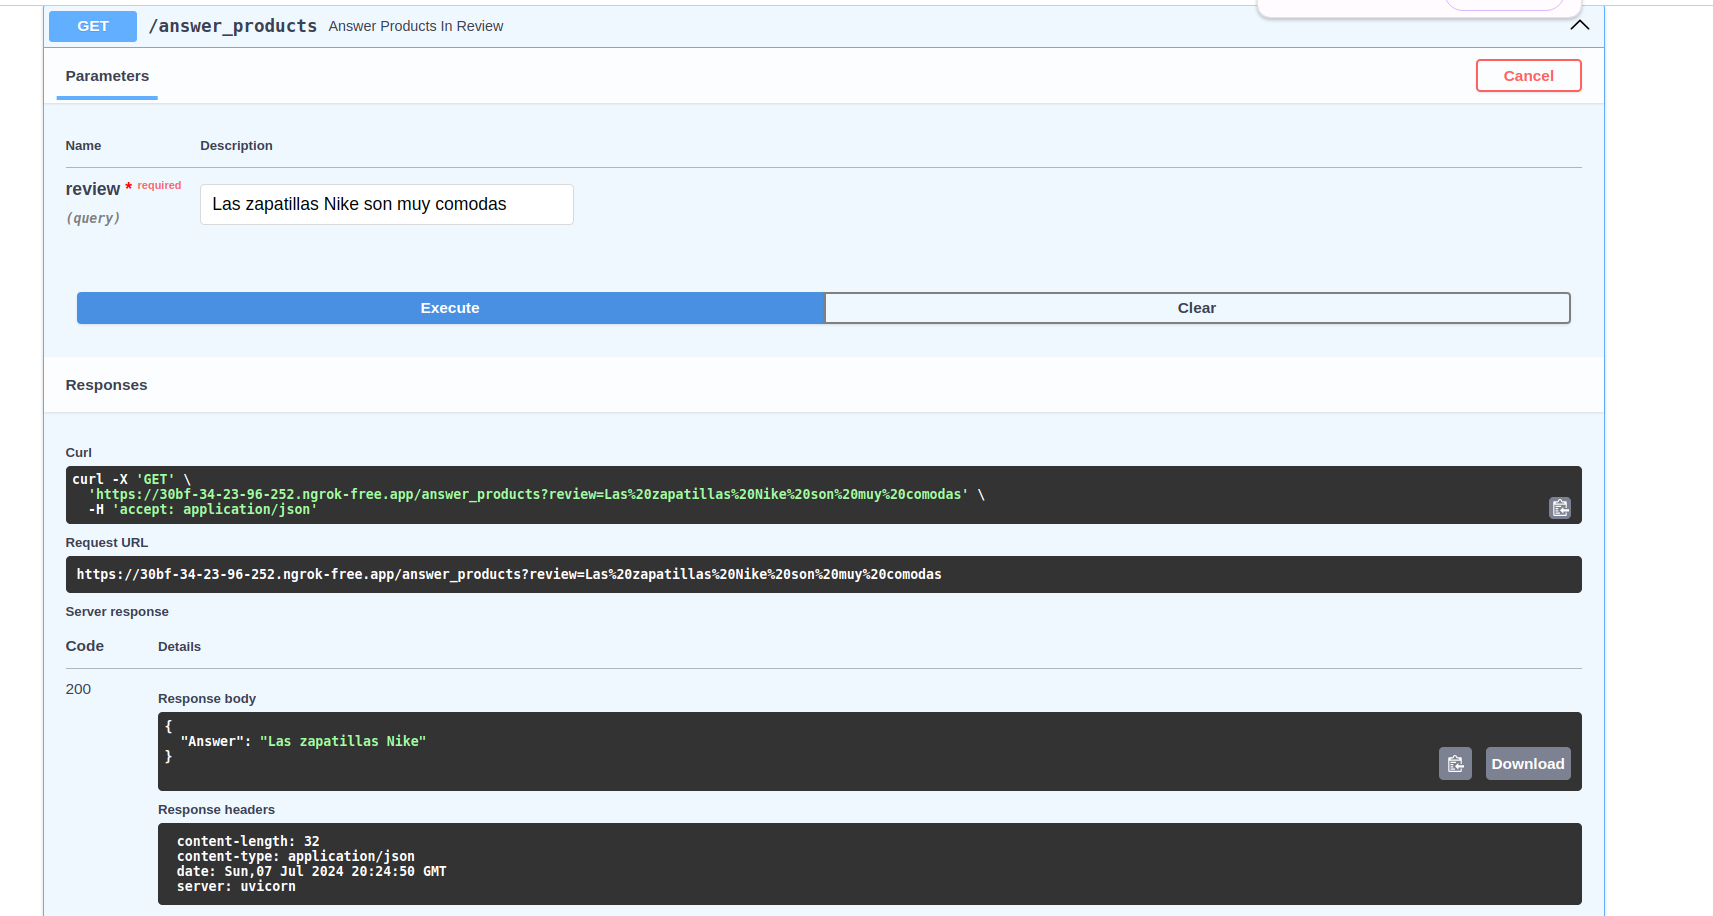

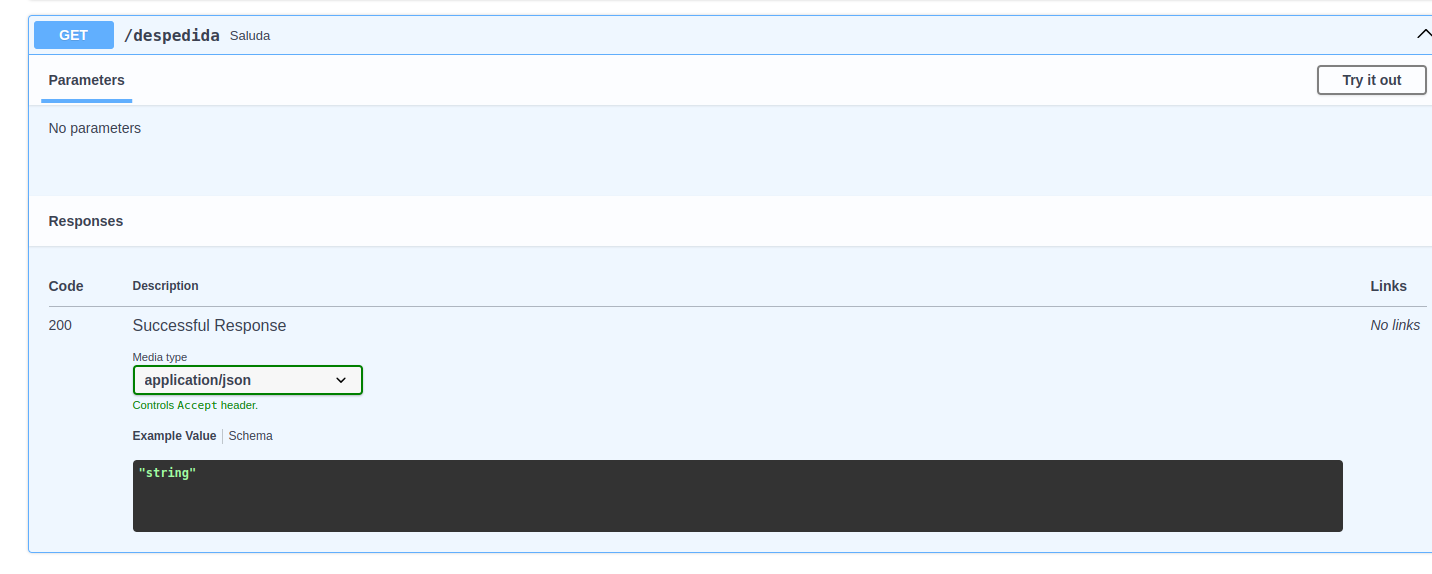

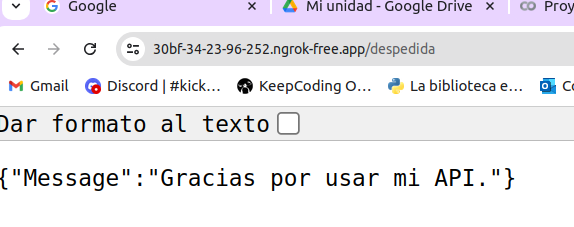